In [ ]:
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.stats import ttest_rel, ttest_ind, sem
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import os

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### Manifold compression for LoRA

In [4]:
def compute_ddc(dis, ref):
    """
    Relative level distance and relative residual distance, global (to target), cluster-mean based.

    params: dis: displacement vector from target point to the attractor. ndarray of shape (day, nl, img, np, pc)
    params: ref: reference vector for all the displacement vector. ndarray of shape (day, 1, img, np, pc)
    return: normalized distance. ndarray of shape (nl, img)
    """
    day, nl, img, npt, pc = dis.shape

    # 2 norm of noise covariance
    noise_mean = dis.mean(-2, keepdims=True)
    noise_cov = ((dis - noise_mean).transpose(0, 1, 2, 4, 3) @ (dis - noise_mean)) / npt  # day, nl, img, pc, pc
    noise_norm = np.trace(noise_cov, axis1=-2, axis2=-1)  # day, nl, img

    # distance between noise and clear
    dis_pavg = dis.mean(-2)  # day, nl, img, pc
    ref_pavg = ref.mean(-2)  # day, 1, img, pc
    noise_dist = norm(dis_pavg - ref_pavg, axis=-1)**2  # day, nl, img

    # 2 norm of signal covariance
    signal_mean = dis_pavg.mean(-2, keepdims=True)  # day, nl, 1, pc
    signal_cov = ((dis_pavg - signal_mean).transpose(0, 1, 3, 2) @ (dis_pavg - signal_mean)) / img  # day, nl, pc, pc
    signal_norm = np.trace(signal_cov, axis1=-2, axis2=-1)  # day, nl
    # ddc_ratio = euc_dist ** 2 / np.expand_dims(variance, -1)  # day, nl, img
    ddc_ratio = np.sqrt(noise_dist) / np.sqrt(np.expand_dims(signal_norm, -1))
    pdc_ratio = np.sqrt(noise_norm) / np.sqrt(np.expand_dims(signal_norm, -1))
    
    return ddc_ratio, pdc_ratio, [np.sqrt(noise_dist), np.sqrt(noise_norm), np.sqrt(signal_norm)]  # day, nl, img, [noise_dist, noise_norm, signal_norm]


def compute_ddc2(dis):
    """
    Relative level distance and relative residual distance, local, sample-centric.

    params: dis: displacement vector from target point to the attractor. ndarray of shape (day, nl, img, np, pc)
    return: normalized distance. ndarray of shape (nl, img)
    """
    day, nl, img, npt, pc = dis.shape
    noise_norm = np.zeros((day, nl, img, npt))
    noise_dist = np.zeros((day, nl, img, npt))
    signal_norm = np.zeros((day, nl, img, npt))

    for i in range(npt):
        # noise variance
        dis_i = dis[:, :, :, i, :][:, :, :, np.newaxis, :]  # day, nl, img, 1, pc
        noise_norm_i = np.sqrt(np.mean(np.linalg.norm(dis - dis_i, axis=-1)**2, axis=-1))  # day, nl, img
        noise_norm[..., i] = noise_norm_i

        # level distance
        noise_dist_i = np.sqrt(np.mean(np.linalg.norm(dis_i - np.roll(dis, 1, axis=1), axis=-1)**2, axis=-1))  # day, nl, img
        noise_dist[..., i] = noise_dist_i

        # signal variance
        signal_idx = np.arange(img)
        for j in range(img):
            dis_ij = dis[:, :, j, i, :][:, :, np.newaxis, :]  # day, nl, 1, pc
            signal_idx_noi = np.delete(signal_idx, j)
            signal_ = dis[:, :, signal_idx_noi, :, :].reshape(day, nl, (img-1)*npt, pc)  # day, nl, (img-1)*npt, pc
            signal_norm_ij = np.sqrt(np.mean(np.linalg.norm(signal_ - dis_ij, axis=-1)**2, axis=-1))  # day, nl
            signal_norm[:, :, j, i] = signal_norm_ij
    
    # ddc_ratio = euc_dist ** 2 / np.expand_dims(variance, -1)  # day, nl, img
    ddc_ratio = noise_dist / signal_norm  # day, nl, img, npt
    pdc_ratio = noise_norm / signal_norm  # day, nl, img, npt

    return ddc_ratio.mean(-1), pdc_ratio.mean(-1), [noise_dist.mean(-1), noise_norm.mean(-1), signal_norm.mean(-1)]  # day, nl, img, [noise_dist, noise_norm, signal_norm]

In [12]:
def compression_lora(layer, type='output', w_lora=True, n_pc=None):
    """
    One function for all fixed point analysis
    """
    lora_dir = f'w_lora/lora_in_proj_initial_not_train/lora_r8' if w_lora else f'wo_lora' # dir may change
    ys_all_20 = np.load(os.path.join(lora_dir, 'manifold_data_2', f'transformer_block_{layer}_features_{type}.npy'))
    ys_all_100 = np.load(os.path.join(lora_dir, 'manifold_data_20', f'transformer_block_{layer}_features_{type}.npy'))
    ys_all = np.concatenate((ys_all_20, ys_all_100[2:]), axis=0)  # (e*nimg*nl*np, neuron_num)
    orig_shape = ys_all.shape[:-1]
    epoch_num = orig_shape[0]
    neuron_num = ys_all.shape[-1]

    # ------- PCA for calculating distance / visualize
    if n_pc is not None:
        pca = PCA(n_components=n_pc)
        ys_all = ys_all.reshape(-1, neuron_num)  # (e*nimg*nl*np, neuron_num)
        X = pca.fit_transform(ys_all).reshape(*orig_shape, n_pc)  # (e, n_img, n_levels, n_patterns, n_pc)
    else:
        X = ys_all

    # ------ calculate reference, target and distance
    # don't mean or sample nl, mean nl after calculate the matrices
    X = X.transpose(0, 2, 1, 3, 4)  # day, nl, img, np, pc
    target = X[:, 0].mean(axis=(1, 2)).reshape(epoch_num, 1, 1, 1, -1)  # day, 1, 1, 1, pc
    dis = X - target  # day, nl, img, np, pc
    ref = dis[:, [0]]  # day, 1, img, np, pc

    # -------- ddc, pdc
    # ddc, pdc, individual_dist = compute_ddc(dis, ref)  # day, nl, img
    ddc, pdc, individual_dist = compute_ddc2(dis)  # day, nl, img

    return ddc, pdc, individual_dist

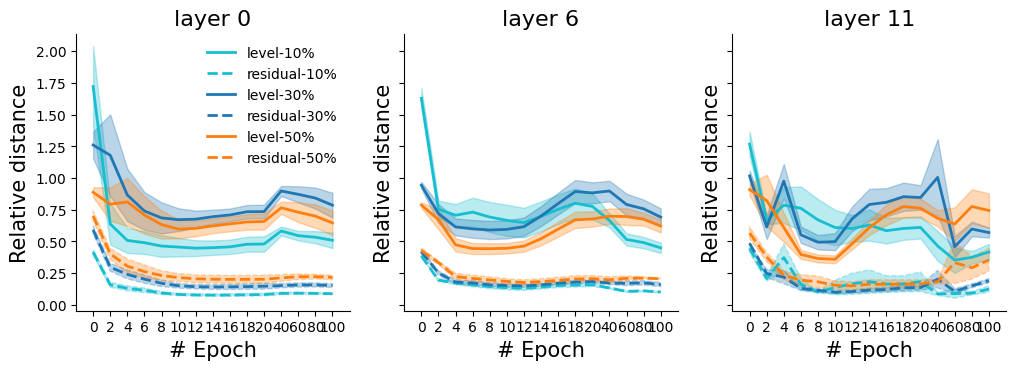

In [21]:
# plot
lora = False
layers = (0, 6, 11)  # layers to plot

levels = (1, 2, 3)  # noise levels
labels = ("10%", "30%", "50%")
cols = ("C9", "C0", "C1")

margin = 1
x_ticks_20 = np.arange(0, 21, 2)
x_ticks_100 = np.arange(0, 101, 20)
x_ticks = np.concatenate((x_ticks_20, x_ticks_100[2:]))  # x ticks for all plots

fig, axs = plt.subplots(1, len(layers), figsize=(4*len(layers), 3.6), sharex=True, sharey=True)
for j, (layer, ax) in enumerate(zip(layers, axs)):
    # compute metrics for compression
    ddc, pdc, individual_dist = compression_lora(layer, type='output', w_lora=lora, n_pc=None)
    x = np.arange(ddc.shape[0])

    # plotting
    for n, (i, label) in enumerate(zip(levels, labels)):
        ddc_i = ddc[:, i]  # day, img
        pdc_i = pdc[:, i]  # day, img
        ddci_mean = ddc_i.mean(-1)
        ddci_sem = sem(ddc_i, -1)
        pdci_mean = pdc_i.mean(-1)
        pdci_sem = sem(pdc_i, -1)

        ax.plot(x, ddci_mean, '-', color=cols[n], lw=2, label=f'level-{label}')
        ax.fill_between(x, ddci_mean+ddci_sem, ddci_mean-ddci_sem, color=cols[n], alpha=.3)
        ax.plot(x, pdci_mean, '--', color=cols[n], lw=2, label=f'residual-{label}')
        ax.fill_between(x, pdci_mean+pdci_sem, pdci_mean-pdci_sem, color=cols[n], alpha=.3, linestyle='dashed')
        # ax.plot([x[4]], [cds_mean[4]], 'o', markersize=7, mec='white', mfc=cols[n])
        # ax.plot([x[2]], [cds2_mean[2]], 'o', markersize=7, mec='white', mfc=cols[n])
        
        ax.set_title(f'layer {layer}', fontsize=16)
        ax.set_xticks(x, x_ticks, rotation=0)
        ax.set(xlim=[x[0]-margin, x[-1]+margin])
        ax.set_xlabel('# Epoch')
        ax.set_ylabel('Relative distance')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.grid(color='0.5', linestyle='--', linewidth=0.5)
    
        if j == 0:
            ax.legend(loc='upper right', frameon=False)

# plt.savefig('met.png')

#### Population tuning lora

In [4]:
def pop_response(tuning_pre, tuning_post, mode='pre'):
    """
    Calculate the population response curve for a given tuning matrix.

    """
    tuning_pre = np.abs(tuning_pre)
    tuning_post = np.abs(tuning_post)

    if mode == 'pre':
        neuron_idx_pre = np.argsort(tuning_pre, axis=1)[:, ::-1]
        neuron_idx_post = neuron_idx_pre
    elif mode == 'post':
        neuron_idx_post = np.argsort(tuning_post, axis=1)[:, ::-1]
        neuron_idx_pre = neuron_idx_post
    elif mode == 'both':
        neuron_idx_post = np.argsort(tuning_post, axis=1)[:, ::-1]
        neuron_idx_pre = np.argsort(tuning_pre, axis=1)[:, ::-1]
    
    tuning_pre_sorted = np.take_along_axis(tuning_pre, neuron_idx_pre, axis=1)
    tuning_post_sorted = np.take_along_axis(tuning_post, neuron_idx_post, axis=1)
    
    # rel_diff = (tuning_post_sorted - tuning_pre_sorted) / (tuning_pre_sorted + tuning_post_sorted + 1e-8)
    return tuning_pre_sorted, tuning_post_sorted

In [ ]:
def analyze_pop_tuning(layer, num_img, type='output', w_lora=True):
    """
    All code in one for sparsity analysis
    """
    # load data
    lora_dir = f'LoRA_{num_img}_img/w_lora/' if w_lora else f'LoRA_{num_img}_img/wo_lora/'
    tm_all = np.load(f'{lora_dir}transformer_block_{layer}_features_{type}.npy')

    # flatten images
    tmc = tm_all[:, :, 0, 0, :]  # (e, n_img, neuron_num)
    tmc_before = tmc[0]  # (n_img, neuron_num)
    tmc_after = tmc[-1]  # (n_img, neuron_num)

    # calculate population tuning
    tmc_before, tmc_after = pop_response(tmc_before, tmc_after, mode='both')  # (n_img, neuron_num)
    # pop_diff_mean = pop_diff.mean(0)  # (neuron_num,)

    tmc_before_mean = tmc_before.mean(0)
    tmc_after_mean = tmc_after.mean(0)
    tmc_before_mean_norm = tmc_before_mean / np.max(tmc_before_mean)
    tmc_after_mean_norm = tmc_after_mean / np.max(tmc_after_mean)

    # return pop_diff_mean
    return tmc_before_mean_norm, tmc_after_mean_norm  # (neuron_num)


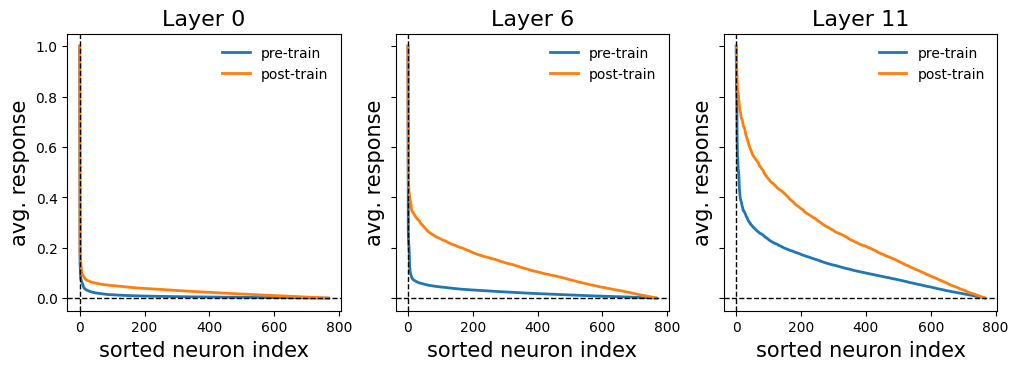

In [7]:
layers = (0, 6, 11)  # layers to analyze
num_img = 4  # number of images
w_lora = True  # whether to use LoRA

fig, axs = plt.subplots(1, len(layers), figsize=(4*len(layers), 3.6), sharex=True, sharey=True)
for layer, ax in zip(layers, axs):
    avg_tuning_before, avg_tuning_after = analyze_pop_tuning(layer, num_img, w_lora=w_lora)

    ax.plot(avg_tuning_before, label='pre-train', linewidth=2, alpha=1)
    ax.plot(avg_tuning_after, label='post-train', linewidth=2, alpha=1)
    ax.axhline(0, linestyle='dashed', linewidth=1, color='k')
    ax.axvline(x=0, linestyle='dashed', linewidth=1, color='k')
    ax.legend(loc='best', frameon=False)

    ax.set_xlabel('sorted neuron index')  # Increase space
    ax.set_ylabel('avg. response')  # Increase space
    ax.set_title(f'Layer {layer}', fontsize=16)
    # ax.set_xlim(-50, 4000)  # END: